# Lending Club Case Study

It is important for a Lending Club to identify which group of customers might default, meaning they might be charged off and don't return the money, based on their application. If this identification is not performed correctly, it can lead to loss of business in two ways:
- If the application of the customers who fully pay their loan, is mistakenly rejected, then this will lead to the loss of business.
- If the application of the defaulters are approved, and then later they are charged off and don't return the money back, then this will also lead to loss of business.

In this project the dataset, containing the history of customers of a Lending Club is given, with the information about whether each customer has been charged off or fully paid back the loan.

The objective is to identify the groups of customers who are most likely to default, and advise this to the business.

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
def drop_nan_cols(df, threshold = 0.2):
    """
    This function drops the columns of the df if the number of 'NaN's of the column is beyond a limit.
    The limit (threshold) is the ratio of the number of 'NaN's to the number of rows of the df.
    """
    for col in df.columns:
        if df[col].isna().sum() / df.shape[0] >= threshold:
            df.drop(col, axis=1, inplace=True)

def perc_remove(df, col):
    """
    This function removes '%' from the end of the entries of a column, and returns the result as a float
    e.g. '4.56%' --> 4.56
    """
    df[col] = df[col].apply(lambda x: float(x[:-1]))

def n_months_calc(df, col):
    """
    This function returns a list of number of months for the unique values in the 'col' column of the dataframe 'df'.
    This function assumes the unique() function returns the sorted unique values so that 
    the first element is the latest month and can abe considered as the reference for calculation of the number of months.
    """
    n_months_list = []
    col_uniques = list(df[col].unique())
    ref = col_uniques[0]
    for i in range(len(col_uniques)):
        item = col_uniques[i]
        n_years = int(ref[-2:]) - int(item[-2:])
        n_months = n_years * 12 + (months.index(ref[:3]) - months.index(item[:3]))
        n_months_list.append(n_months)
    
    return n_months_list

def pd_series_ref_label_based_sorter(series, labels):
    """
    This function sorts the unsorted elements of a Pandas Series based on the reference labels.
    The reference labels correspond to the indices of the Pd Series.
    """
    label_based_list = []
    for i in range(len(series)):
        label_based_list.append(series[labels[i]])
    return label_based_list

def plot_histogram(df_col, bins = 30, plt_title = 'Distribution', plt_xlabel = 'Amount', plt_ylabel = 'Frequency'):
    """
    This function produces a histogram of a column of the dataframe, with the input title and labels.
    """
    fig = plt.figure(figsize = (8, 5))
    plt.hist(df_col, bins)
    plt.title(plt_title)
    plt.xlabel(plt_xlabel)
    plt.ylabel(plt_ylabel)
    plt.show()

def plot_freq_count_n_percentage(df, x, y, side_by_side = 1):
    
    """
    This function plots 2 frequency plots below for the categorical columns x and y of a df.
    To be used to observe the frequency counts of different categories of y (target) over categories of x, of interest.
    x: the column whose categories appear on x-axis.
    y: the target column whose categories appear on y-axis.
    first plot: frequency count plots of categories of y over categories of x
    second plot: percentage frequency count plots of the first plot
    
    if side_by_side = 1, the function will give 2 side by side plot. 
    otherwise if side_by_side = 0, the plots will be one above the other.
    """
    
    # 'colors' has 7 values. Therefore, this works for x (target) column having maximum 7 categories as of 4/5/2022
    colors = ['green', 'red', 'yellow', 'blue', 'cyan', 'magenta', 'orange']

    x_uniques = df[x].unique()
    y_uniques = df[y].unique()

    labels = x_uniques
    width = 0.3 # the width of the bars

    if side_by_side == 1:
        fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    elif side_by_side == 0:
        fig, ax = plt.subplots(2, 1, figsize = (15, 10))
    else:
        print("This function plots 2 frequency plots. 'side_by_side' should be either 0 or 1!")

    cnt_clr = 1
    counts_per_y_cat_whole = () # a tuple is defined as it was observed python changes the content without any reason!
    for unique_val in y_uniques:
        counts_per_y_cat = pd_series_ref_label_based_sorter(df[df[y] == unique_val][x].value_counts(), labels)
        counts_per_y_cat_tuple = tuple(counts_per_y_cat)
        counts_per_y_cat_whole += (counts_per_y_cat_tuple, )
        if unique_val == y_uniques[0]:
            bars = ax[0].bar(labels, counts_per_y_cat, width, label= unique_val, color = colors[0])
            heights = counts_per_y_cat
            for i in range(len(labels)):
                h = bars[i].get_height()
                ax[0].text(labels[i], h/2, str(h), ha="center")
        else:
            bars = ax[0].bar(labels, counts_per_y_cat, width, label=unique_val, bottom=heights, color = colors[cnt_clr])
            cnt_clr += 1
            for i in range(len(labels)):
                h = bars[i].get_height()
                ax[0].text(labels[i], heights[i] + h/2, str(h), ha="center")
                heights[i] += counts_per_y_cat[i]

    ax[0].set_ylabel('Frequency')
    ax[0].set_title("Frequency of '" + y + "' vs categories of '" + x + "'")
    ax[0].legend(title = y, loc='upper right')
    ax[0].set_xticklabels(labels, rotation = 15)

    cnt_clr = 1
    for i in range(len(y_uniques)):
        percentages_per_y_cat = []
        for j in range(len(x_uniques)):
            tot_sum = 0.0
            for k in range(len(y_uniques)):
                tot_sum += counts_per_y_cat_whole[k][j]
            percentages_per_y_cat.append(counts_per_y_cat_whole[i][j] / tot_sum * 100.0)
        if i == 0:
            bars = ax[1].bar(labels, percentages_per_y_cat, width, label= y_uniques[i], color = colors[0])
            heights = percentages_per_y_cat
            for j in range(len(labels)):
                h = bars[j].get_height()
                ax[1].text(labels[j], h/2, str(h)[:str(h).index('.')+3], ha="center")
        else:
            bars = ax[1].bar(labels, percentages_per_y_cat, width, label=y_uniques[i], bottom=heights, color = colors[cnt_clr])
            cnt_clr += 1
            for j in range(len(labels)):
                h = bars[j].get_height()
                ax[1].text(labels[j], heights[j] + h/2, str(h)[:str(h).index('.')+3], ha="center")
                heights[j] += percentages_per_y_cat[j]

    ax[1].set_ylabel('Frequency percentages (%)')
    ax[1].set_title("Frequency % of '" + y + "' vs categories of '" + x + "'")
    ax[1].legend(title = y, loc='lower right')
    ax[1].set_xticklabels(labels, rotation = 15)

    plt.show()


# Data Understanding

In [3]:
# setting some values
warnings.filterwarnings('ignore')

threshold_nan_col = 0.5 # minimum ratio of a column's 'NaN's to the number of rows of the df, to be dropped off
# The above value below was advised by an expert.
threshold_nan_row = 0.1
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### Importing the dataframe

In [4]:
df0 = pd.read_csv('loan.csv')
df0.shape

(39717, 111)

#### Dropping the columns with more than 50% NaN values

In [5]:
drop_nan_cols(df0, threshold_nan_col)
df0.shape

(39717, 54)

By dropping the columns that have more than 50% NaN values, the number of columns reduced to 54 from 111.

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

It seems there are NaN values in some of the columns, e.g. 'emp_length', etc. This will be dealt with later.

#### Columns to be dropped
Several columns of the dataframe have been removed due to the following reasons:
- following columns related to customer behavior since these are used at the time of revieweing the loan application and before approving the application. However, now that all the applications of the customers are approved, these columns are irrelevant to this study: delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, application_type
- the geographic location of the applicant (i.e. zip_code, and addr_state) has no impact on the 'loan_status' (assumption)
- columns that have only one unique value, i.e. pymnt_plan, initial_list_status, policy_code, acc_now_delinq, delinq_amnt
- the ID columns, i.e. 'id', 'member_id', since these are randomly generated numbers and have no impact on the 'loan-status'.
- 'sub_grade' since the 'grade' is already in data, and there is no need for any further granularity.
- URL column (url), loan description (desc), loan title (title) since these have no impact on the 'loan_status'.
- 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens': have only 0 and NaNs, meaning any imputation will lead to considering 0 values for NaNs, which will lead to a unique value of 0 for the whole column.
- 'emp_title' since there are more than 28000 employment titles, and also it is assumed that the type of people's job (employment title) has no imapct on the default of the customers (being charged off).

In [7]:
# columns to be dropped from the dataframe
cols_drop = ['delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', \
             'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', \
             'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', \
             'last_credit_pull_d', 'application_type', 'id', 'member_id', 'sub_grade', 'url', 'desc', 'pymnt_plan', \
             'title', 'zip_code', 'addr_state', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', \
            'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'emp_title']

In [8]:
for col in cols_drop:
    df0.drop(col, axis=1, inplace=True)

In [9]:
df0['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

The customers with the loan_status of 'Current' are removed from the dataframe, since it is unknown whether they will be charged off (default) or not.

In [10]:
df1 = df0[~(df0['loan_status'] == 'Current')]

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   emp_length            37544 non-null  object 
 8   home_ownership        38577 non-null  object 
 9   annual_inc            38577 non-null  float64
 10  verification_status   38577 non-null  object 
 11  issue_d               38577 non-null  object 
 12  loan_status           38577 non-null  object 
 13  purpose               38577 non-null  object 
 14  dti                   38577 non-null  float64
 15  pub_rec_bankruptcie

As the last stage in 'Data Understanding', let's look at the first few rows from the top and bottom of the dataframe.

In [12]:
df1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,27.65,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,1.00,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,8.72,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,20.00,0.0
5,5000,5000,5000.0,36 months,7.90%,156.46,A,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,wedding,11.20,0.0


In [13]:
df1.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,pub_rec_bankruptcies
39712,2500,2500,1075.0,36 months,8.07%,78.42,A,4 years,MORTGAGE,110000.0,Not Verified,Jul-07,Fully Paid,home_improvement,11.33,NaN
39713,8500,8500,875.0,36 months,10.28%,275.38,C,3 years,RENT,18000.0,Not Verified,Jul-07,Fully Paid,credit_card,6.40,NaN
39714,5000,5000,1325.0,36 months,8.07%,156.84,A,< 1 year,MORTGAGE,100000.0,Not Verified,Jul-07,Fully Paid,debt_consolidation,2.30,NaN
39715,5000,5000,650.0,36 months,7.43%,155.38,A,< 1 year,MORTGAGE,200000.0,Not Verified,Jul-07,Fully Paid,other,3.72,NaN
39716,7500,7500,800.0,36 months,13.75%,255.43,E,< 1 year,OWN,22000.0,Not Verified,Jun-07,Fully Paid,debt_consolidation,14.29,NaN


# Data Cleaning
As was seen, all the columns have non-null values except the columns 'emp_length' and 'pub_rec_bankruptcies', which are both categorical. Hence, for these columns, the most frequent element in the column is replaced with the NaN values. (the number of rows (data entries) that are affected are less than 4.50% of the entire rows. Hence, this doesn't significantly impact the analysis.)

In [14]:
cols_with_nan = ['emp_length', 'pub_rec_bankruptcies']
for col in cols_with_nan:
    df1[col].fillna(df1[col].mode()[0], inplace=True)

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   emp_length            38577 non-null  object 
 8   home_ownership        38577 non-null  object 
 9   annual_inc            38577 non-null  float64
 10  verification_status   38577 non-null  object 
 11  issue_d               38577 non-null  object 
 12  loan_status           38577 non-null  object 
 13  purpose               38577 non-null  object 
 14  dti                   38577 non-null  float64
 15  pub_rec_bankruptcie

Just to doublle-check: it can be seen that now, none of the columns have null (NaN) values.


### Sanity check
#### loan_amnt, funded_amnt, and funded_amnt_inv
loan_amnt is the amount the customer applies for. funded_amnt is the loan amount the Lending Club approves, which is less than or equal to loan_amnt. funded_amnt_inv is the amount of loan that is actually funded by the investor, which is less than or equal to funded_amnt. In other words, the following condition should always be met:

funded_amnt_inv <= funded_amnt <= loan_amnt

Hence, the breach from the above condition, which is the condition below, has been checked.

In [16]:
df1[(df1['funded_amnt_inv'] > df1['funded_amnt']) & (df1['funded_amnt'] > df1['loan_amnt'])]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,pub_rec_bankruptcies


As can be seen, no breach from the above condition is observed in the data.

Before moving to the next step, i.e. data analysis, almost all the columns needs some amendments or transofrmation, in order to prepare the dataframe for the next step, i.e. data analysis.


### Preparing columns for data analysis

#### loan_status

This is a perfect categorised column, however, the categories are changed to 0 (if the customer was not charged off), and 1 (if the customer was charged off)

In [17]:
df1['charged_off?'] = df1['loan_status'].apply(lambda x: '0' if x == 'Fully Paid' else '1')

#### int_rate


Interest rate is expected to be in a float format, however, it is an object. So, the content of the column needs to be observed.

In [18]:
df1['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

It can be seen that the '%' is in front of the values, and this has caused the problem. The '%' is removed as below.

In [19]:
perc_remove(df1, 'int_rate')
df1['int_rate'].head()

0    10.65
1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: float64

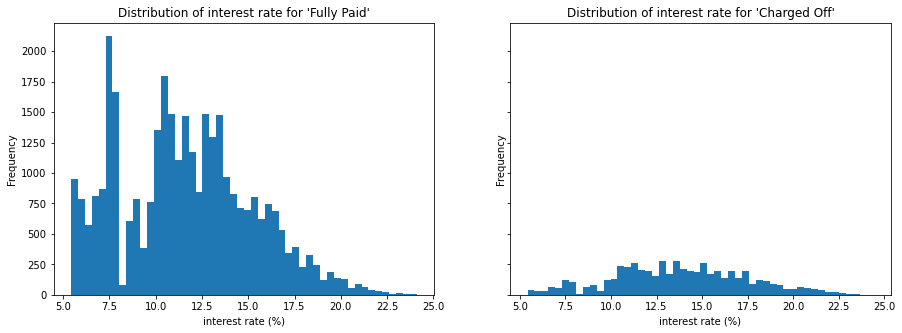

In [20]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 5))

ax[0].hist(df1[df1['charged_off?'] == '0']['int_rate'], 50)
ax[1].hist(df1[df1['charged_off?'] == '1']['int_rate'], 50)

ax[0].set_title("Distribution of interest rate for 'Fully Paid'")
ax[0].set_xlabel('interest rate (%)')
ax[0].set_ylabel('Frequency')

ax[1].set_title("Distribution of interest rate for 'Charged Off'")
ax[1].set_xlabel('interest rate (%)')
ax[1].set_ylabel('Frequency')

plt.show()

Looking to the distribution of interest rate for both groups of customers, this column is bucketed as below.

In [21]:
df1['int_rate_cat'] = df1['int_rate']. apply(lambda x: '7.5-' if x <= 7.5 \
                                              else '7.5-10' if x <= 10.0 \
                                              else '10-15' if x <= 15.0 \
                                              else '15-20' if x <= 20.0 \
                                              else '20+')

#### emp_length

As can be seen, the employment length has several elements (per number of years actually), however, these have been binned into the main buckets of '0-1 yrs', '2-5 yrs', '6-9 yrs', and '10+ yrs'.

In [22]:
df1['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years'],
      dtype=object)

In [23]:
df1['emp_length_cat'] = df1['emp_length'].apply(lambda x : '0-1 yrs' if x  in ['< 1 year', '1 year'] \
                                                else '2-5 yrs' if x in ['2 years', '3 years', '4 years', '5 years'] \
                                               else '6-9 yrs' if x in ['6 years', '7 years', '8 years', '9 years',]\
                                               else '10+ yrs')

#### loan_amnt

Based on the below distribution, loan_amnt is bucketed as below.

In [24]:
df1['loan_amnt'].describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

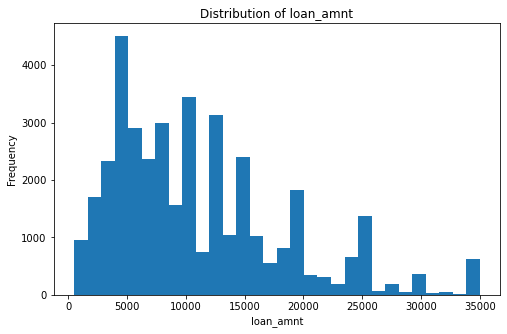

In [25]:
plot_histogram(df1['loan_amnt'], 30, 'Distribution of loan_amnt', 'loan_amnt')

In [26]:
df1['loan_amnt_cat'] = df1['loan_amnt']. apply(lambda x: '0.5-5k' if x <= 5000 \
                                              else '5k-10k' if x <= 10000 \
                                              else '10k-20k' if x <= 20000 \
                                              else '20k-30k' if x <= 30000 \
                                              else '30k-35k')

#### funded_amnt

Based on the below distribution, funded_amnt is bucketed as below.

In [27]:
df1['funded_amnt'].describe()

count    38577.000000
mean     10784.058506
std       7090.306027
min        500.000000
25%       5200.000000
50%       9550.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

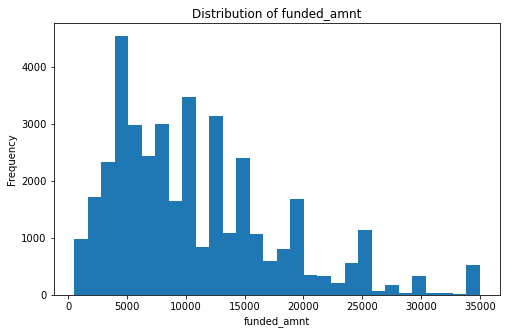

In [28]:
plot_histogram(df1['funded_amnt'], 30, 'Distribution of funded_amnt', 'funded_amnt')

In [29]:
df1['funded_amnt_cat'] = df1['funded_amnt']. apply(lambda x: '0.5-5k' if x <= 5000 \
                                              else '5k-10k' if x <= 10000 \
                                              else '10k-20k' if x <= 20000 \
                                              else '20k-30k' if x <= 30000 \
                                              else '30k-35k')

#### funded_amnt_inv

Based on the below distribution, funded_amnt_inv is bucketed as below.

In [30]:
df1['funded_amnt_inv'].describe()

count    38577.000000
mean     10222.481123
std       7022.720644
min          0.000000
25%       5000.000000
50%       8733.440000
75%      14000.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

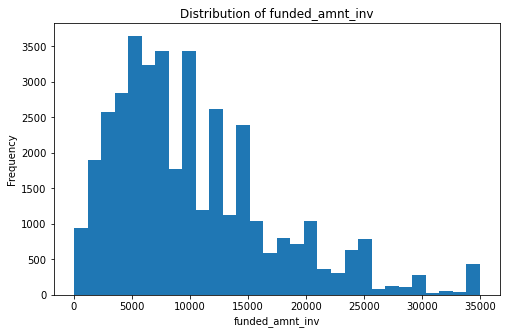

In [31]:
plot_histogram(df1['funded_amnt_inv'], 30, 'Distribution of funded_amnt_inv', 'funded_amnt_inv')

In [32]:
df1['funded_amnt_inv_cat'] = df1['funded_amnt_inv']. apply(lambda x: '0-5k' if x <= 5000 \
                                              else '5k-10k' if x <= 10000 \
                                              else '10k-20k' if x <= 20000 \
                                              else '20k-30k' if x <= 30000 \
                                              else '30k-35k')

#### annual_inc

Based on the below distribution (with the shown details/breakdown below), annual_inc is bucketed as below.

In [33]:
df1['annual_inc'].describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

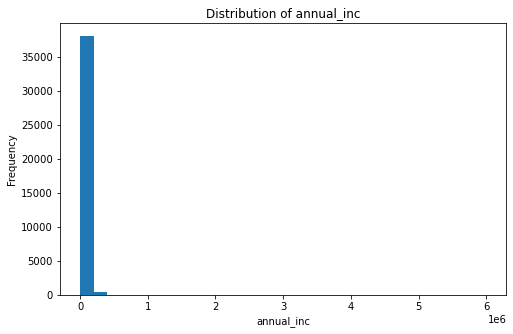

In [34]:
plot_histogram(df1['annual_inc'], 30, 'Distribution of annual_inc', 'annual_inc')

As can be seen, this is highly skewed towards 0. Therefore, 3 histograms are produced corresponding to the 3 below ranges:
- 0.5M to 6M
- 0.2M to 0.5M
- below 0.2M

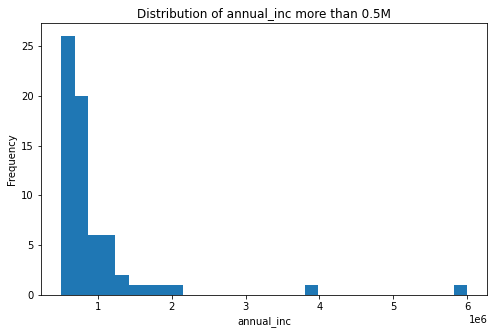

In [35]:
temp1 = df1.loc[df1['annual_inc'] > 500000]
plot_histogram(temp1['annual_inc'], 30, 'Distribution of annual_inc more than 0.5M', 'annual_inc')

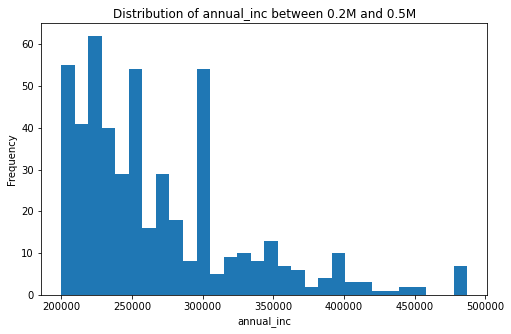

In [36]:
temp2 = df1.loc[(df1['annual_inc'] < 500000) & (df1['annual_inc'] > 200000)]
plot_histogram(temp2['annual_inc'], 30, 'Distribution of annual_inc between 0.2M and 0.5M', 'annual_inc')

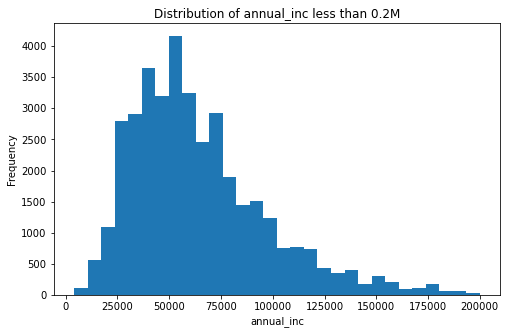

In [37]:
temp3 = df1.loc[df1['annual_inc'] < 200000]
plot_histogram(temp3['annual_inc'], 30, 'Distribution of annual_inc less than 0.2M', 'annual_inc')

In [38]:
df1['annual_inc_cat'] = df1['annual_inc']. apply(lambda x: '0-30k' if x <= 30000 \
                                              else '30k-75k' if x <= 75000 \
                                              else '75k-200k' if x <= 200000 \
                                              else '200k-500k' if x <= 500000 \
                                              else '500k-6M')

#### installment

Based on the below distribution, installment is bucketed as below.

In [39]:
df1['installment'].describe()

count    38577.000000
mean       322.466318
std        208.639215
min         15.690000
25%        165.740000
50%        277.860000
75%        425.550000
max       1305.190000
Name: installment, dtype: float64

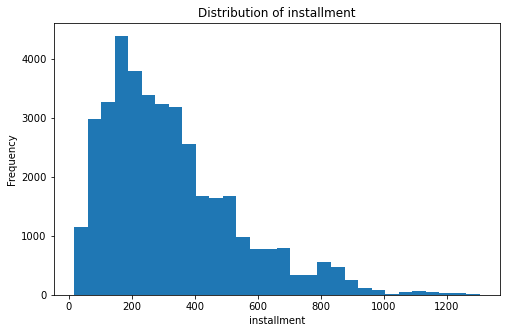

In [40]:
plot_histogram(df1['installment'], 30, 'Distribution of installment', 'installment')

In [41]:
df1['installment_cat'] = df1['installment']. apply(lambda x: '0-100' if x <= 100 \
                                              else '100-300' if x <= 300 \
                                              else '300-600' if x <= 600 \
                                              else '600-800' if x <= 800 \
                                              else '800+')

#### dti

Based on the below distribution, dti is bucketed as below.

In [42]:
df1['dti'].describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

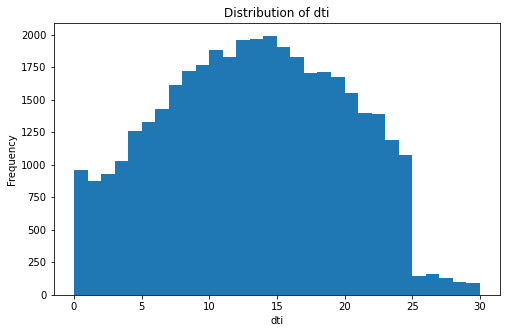

In [43]:
plot_histogram(df1['dti'], 30, 'Distribution of dti', 'dti')

In [44]:
df1['dti_cat'] = df1['dti']. apply(lambda x: '0-5' if x <= 5 \
                                   else '5-10' if x <= 10 \
                                   else '10-15' if x <= 15 \
                                   else '15-20' if x <= 20 \
                                   else '20-25' if x <= 25 \
                                   else '25+')

#### issue_d

The column issue_d is in the form of string, therefore, the number of months with reference to Dec-11 is calculated first. Then, the histogram distribution of the number of months is plotted. Based on this distribution, this columns is bucketed as below.

In [45]:
col = 'issue_d'
n_months_list = n_months_calc(df1, col)

df1['issue_d_n_months'] = df1['issue_d'].apply(lambda x: n_months_list[list(df1['issue_d'].unique()).index(x)])

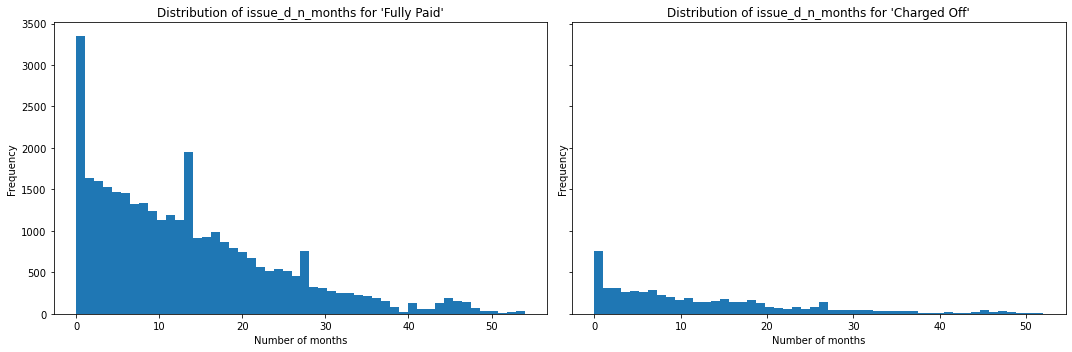

In [46]:
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (15, 5))

ax[0].hist(df1[df1['charged_off?'] == '0']['issue_d_n_months'], 50)
ax[1].hist(df1[df1['charged_off?'] == '1']['issue_d_n_months'], 50)

ax[0].set_title("Distribution of issue_d_n_months for 'Fully Paid'")
ax[0].set_xlabel('Number of months')
ax[0].set_ylabel('Frequency')

ax[1].set_title("Distribution of issue_d_n_months for 'Charged Off'")
ax[1].set_xlabel('Number of months')
ax[1].set_ylabel('Frequency')

plt.show() 

In [47]:
df1['issue_d_cat'] = df1['issue_d_n_months']. apply(lambda x: '0-5mths' if x <= 5 \
                                                    else '5-10mths' if x <= 10 \
                                                    else '10-20mths' if x <= 20 \
                                                    else '20-30mths' if x <= 30 \
                                                    else '30-40mths' if x <= 40 \
                                                    else '40+mths')

#### pub_rec_bankruptcies

This column has 'float64' type. Let's inspect the unique values of it.

In [48]:
df1['pub_rec_bankruptcies'].unique()

array([0., 1., 2.])

As can be seen, the column has only 3 unique float (and not integer) values. In order to transform the column into categories, the float values are made as strings as below.

In [49]:
df1['pub_rec_bankruptcies_cat'] = df1['pub_rec_bankruptcies'].apply(lambda x: '0' if x == 0.0 \
                                                                   else '1' if x == 1.0 \
                                                                   else '2')

# Data Analysis

For the purpose of data analysis, the new categorised columns (made above) are gathered into a new dataframe called df_cat. By doing so, some of the rows of the dataframe have become duplicated. Prior to the transformation, these rows were unique since they were numeric. However, after categorisation, these rows have become duplicated. This can be observed from the number of rows before and after removing these duplicated rows, as below.

In [50]:
cat_cols = ['charged_off?', 'int_rate_cat', 'emp_length_cat', 'loan_amnt_cat', 'funded_amnt_cat', 'funded_amnt_inv_cat', \
            'annual_inc_cat', 'installment_cat', 'dti_cat', 'issue_d_cat', 'term', 'grade', 'home_ownership', \
            'verification_status', 'purpose', 'pub_rec_bankruptcies_cat']
df_cat = df1[cat_cols]

In [51]:
df_cat.shape

(38577, 16)

In [52]:
df_cat.drop_duplicates(inplace = True)

In [53]:
df_cat.shape

(34848, 16)

### Impact of 'int_rate_cat' on 'charged_off?'

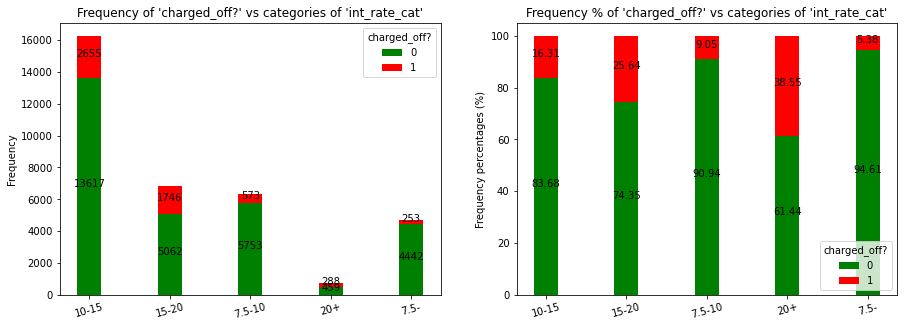

In [54]:
plot_freq_count_n_percentage(df_cat, 'int_rate_cat', 'charged_off?', 1)

As can be seen, the interest rate of more than 20% can potentially be considered as one of the drivers of the customer being charged off, since the percentage of the defaulters in this category of interest rate is much higher than the same percentage in the rest of the categories.


### Impact of 'pub_rec_bankruptcies_cat' on 'charged_off?'

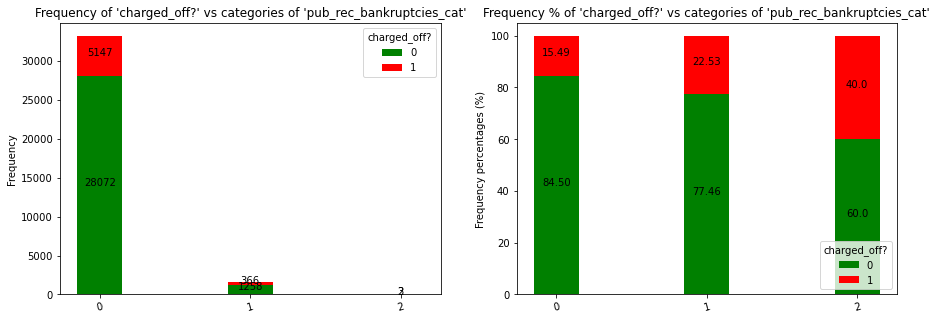

In [55]:
plot_freq_count_n_percentage(df_cat, 'pub_rec_bankruptcies_cat', 'charged_off?', 1)

The customers with 2 public records of bankruptcies are very probable to default.


### Impact of 'purpose' on 'charged_off?'

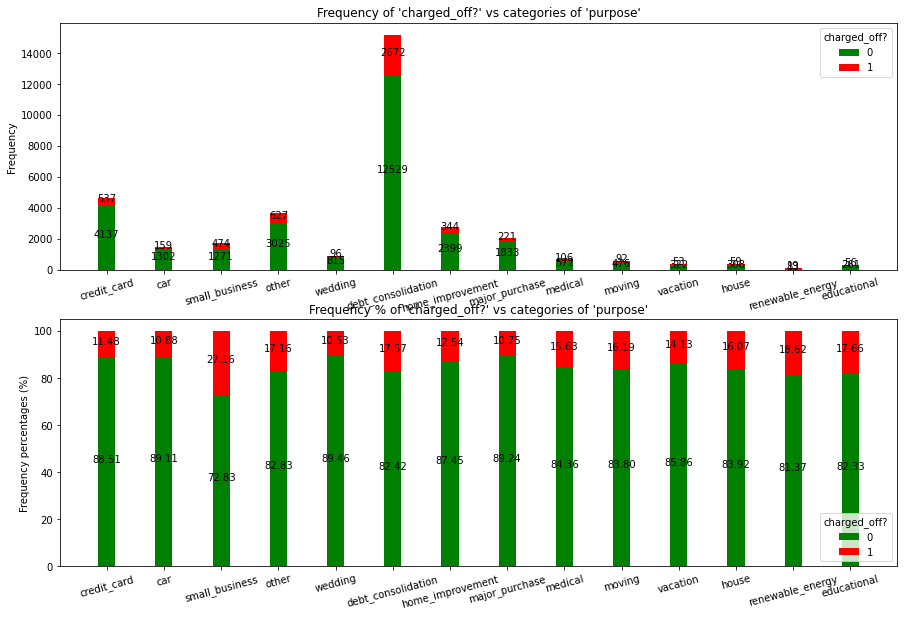

In [56]:
plot_freq_count_n_percentage(df_cat, 'purpose', 'charged_off?', 0)

The loan purpose of 'small business' can also be considered as another driver for the customer to default.


### Impact of 'verification_status' on 'charged_off?'

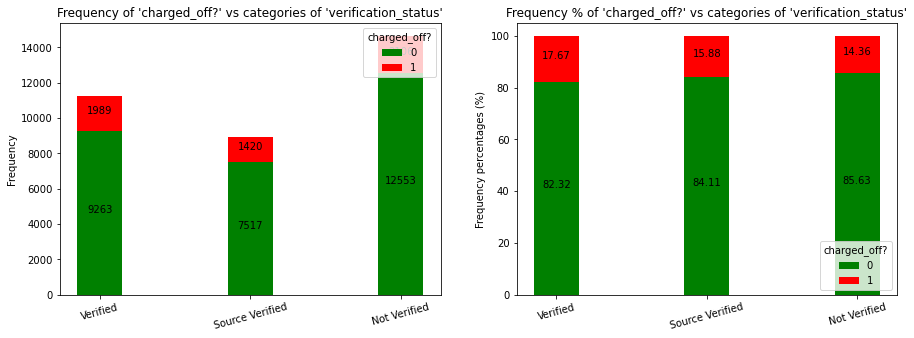

In [57]:
plot_freq_count_n_percentage(df_cat, 'verification_status', 'charged_off?', 1)

Percentage of defaulters in different categories are very similar. Therefore, it is impossible to consider any of the categories as potential to default.

### Impact of 'home_ownership' on 'charged_off?'

As can be seen below, the 'NONE' category in the 'charged_off?' = 0 group, has not any corresponding value in the 'charged_off?' = 1. Therefore, during the plotting, this category has not been considered. Since only 3 records are neglected, this won't impact the analysis.

In [58]:
df_cat[['charged_off?', 'home_ownership']].groupby(['charged_off?', 'home_ownership']).size()

charged_off?  home_ownership
0             MORTGAGE          13211
              NONE                  3
              OTHER                80
              OWN                2468
              RENT              13571
1             MORTGAGE           2279
              OTHER                18
              OWN                 442
              RENT               2776
dtype: int64

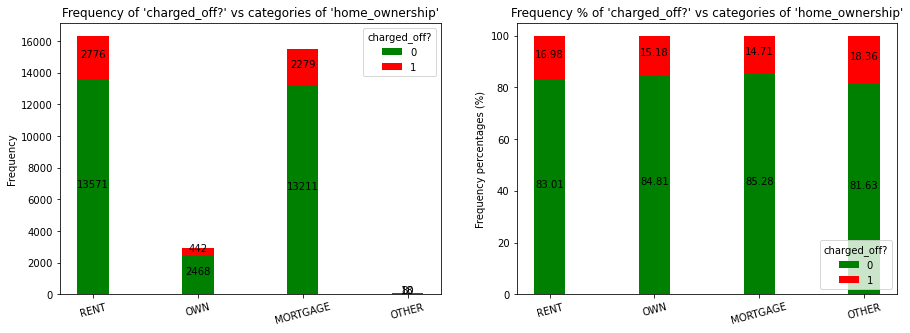

In [59]:
plot_freq_count_n_percentage(df_cat[~(df_cat['home_ownership'] == 'NONE')], 'home_ownership', 'charged_off?', 1)

As can be seen, the share of defaulters in all the categories are almost identical, and hence it is impossible to draw a conclusion for any defaulting driver from this column of the dataframe.


### Impact of 'grade' on 'charged_off?'

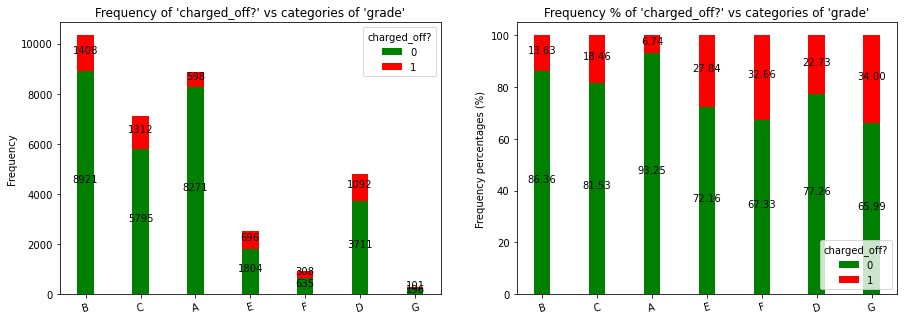

In [60]:
plot_freq_count_n_percentage(df_cat, 'grade', 'charged_off?', 1)

As can be seen, customers with LC assigned loan grade of 'G' is very probable to default due to the much higher percentage of defaulters in this category.


### Impact of 'term' on 'charged_off?'

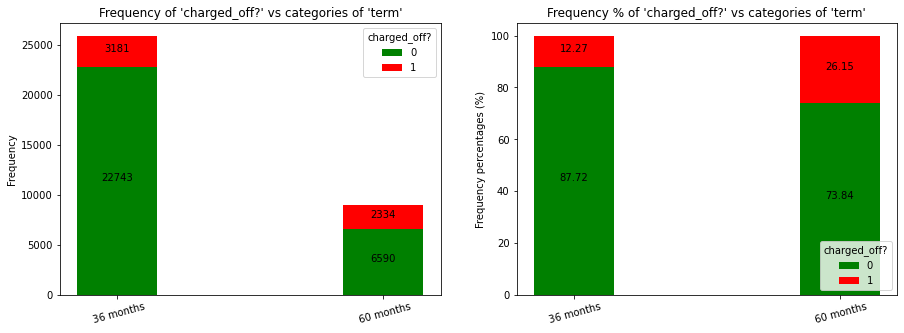

In [61]:
plot_freq_count_n_percentage(df_cat, 'term', 'charged_off?', 1)

The loans with 60 months return term is very probable to be charged off. Hence, this category of loan term can be considered as one of the drivers to default.


### Impact of 'issue_d_cat' on 'charged_off?'

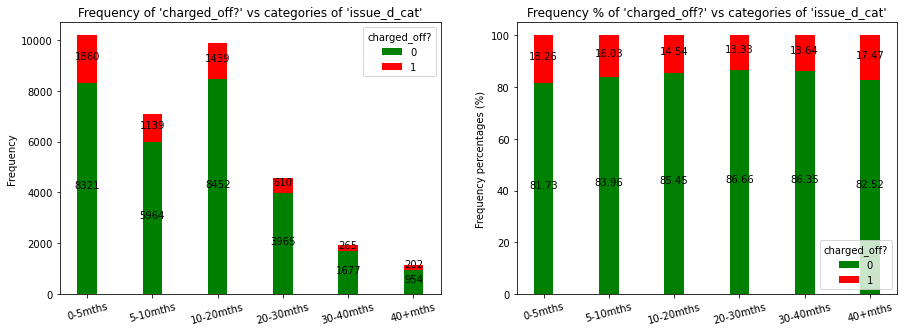

In [62]:
plot_freq_count_n_percentage(df_cat, 'issue_d_cat', 'charged_off?', 1)

As can be seen, the share of defaulters is almost similar in all the categories of this column, and hence no conclusions can be drawn.


### Impact of 'dti_cat' on 'charged_off?'

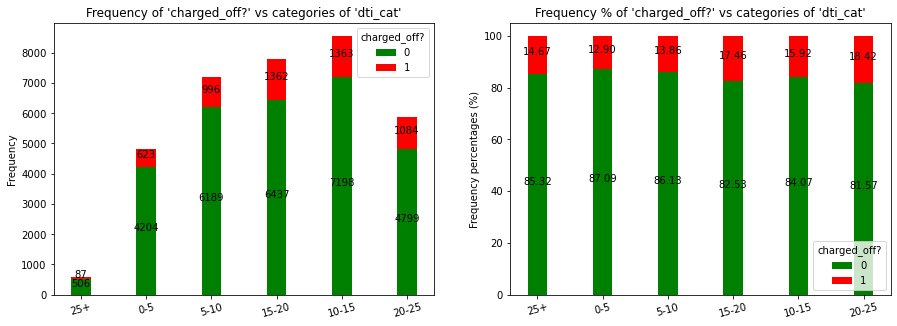

In [63]:
plot_freq_count_n_percentage(df_cat, 'dti_cat', 'charged_off?', 1)

Again, the same share of defaulters in all the categories is observed.


### Impact of 'installment_cat' on 'charged_off?'

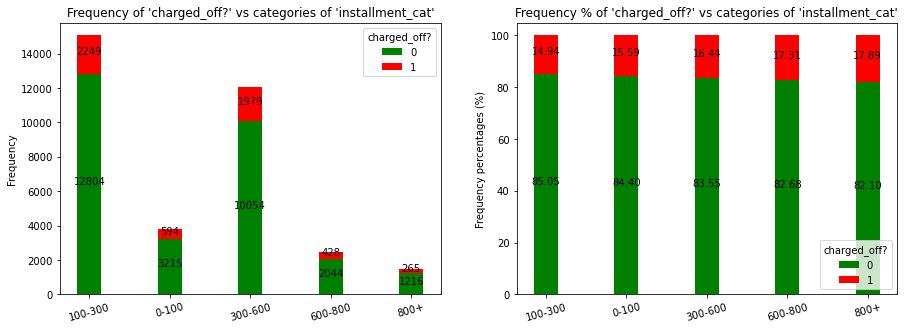

In [64]:
plot_freq_count_n_percentage(df_cat, 'installment_cat', 'charged_off?', 1)

No conclusions for this column of the dataframe can be made since the percentage of defaulters in all the categories are almost similar.


### Impact of 'annual_inc_cat' on 'charged_off?'

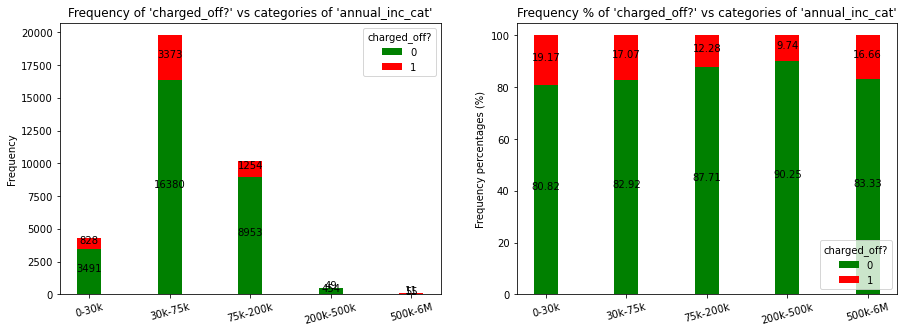

In [65]:
plot_freq_count_n_percentage(df_cat, 'annual_inc_cat', 'charged_off?', 1)

Again, no driver of defaulting from this column can be concluded due to the similar share of charged off customers in all the categories.


### Impact of 'funded_amnt_inv_cat', 'funded_amnt_cat', and 'loan_amnt_cat' on 'charged_off?'

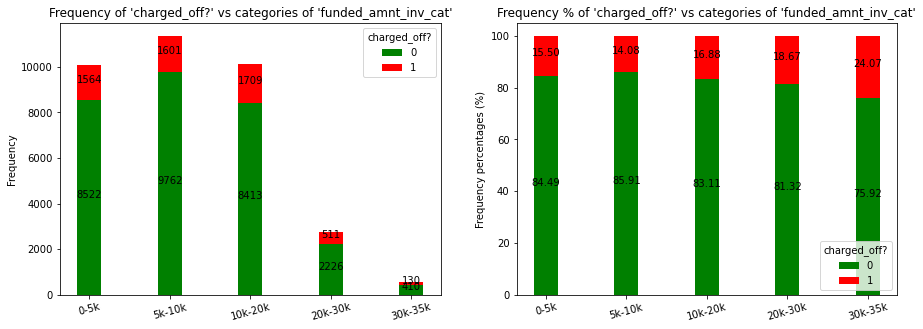

In [66]:
plot_freq_count_n_percentage(df_cat, 'funded_amnt_inv_cat', 'charged_off?', 1)

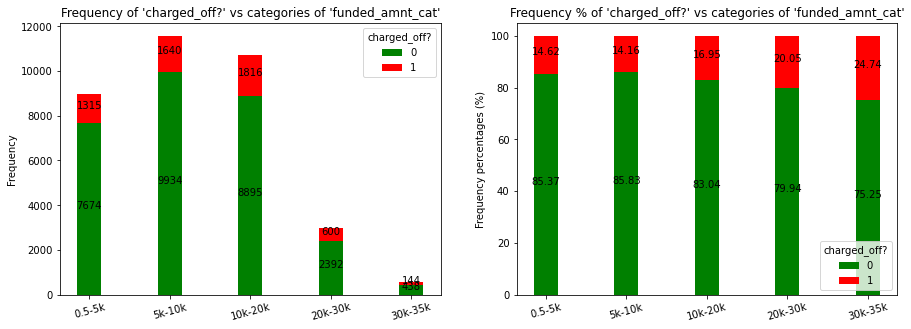

In [67]:
plot_freq_count_n_percentage(df_cat, 'funded_amnt_cat', 'charged_off?', 1)

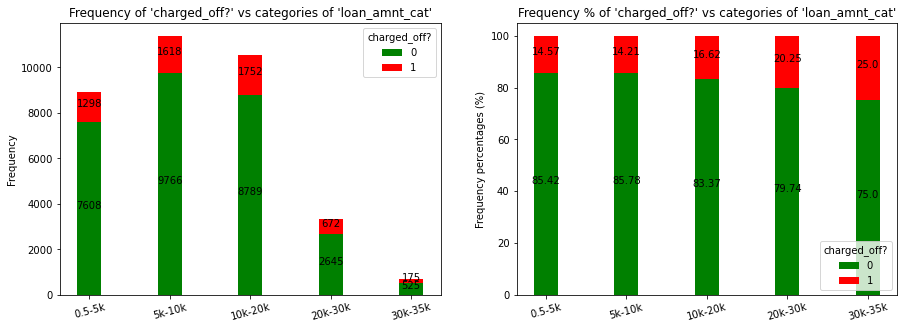

In [68]:
plot_freq_count_n_percentage(df_cat, 'loan_amnt_cat', 'charged_off?', 1)

As can be seen, in all the above graphs, the percentage share of defaulters in the '30k-35k' category is higher compared to the rest of the categories. Hence, this category for 'funded_amnt_inv_cat', 'funded_amnt_cat', and 'loan_amnt_cat' can be considered as one of the drivers for the customer to be charged off.


### Impact of 'emp_length_cat' on 'charged_off?'

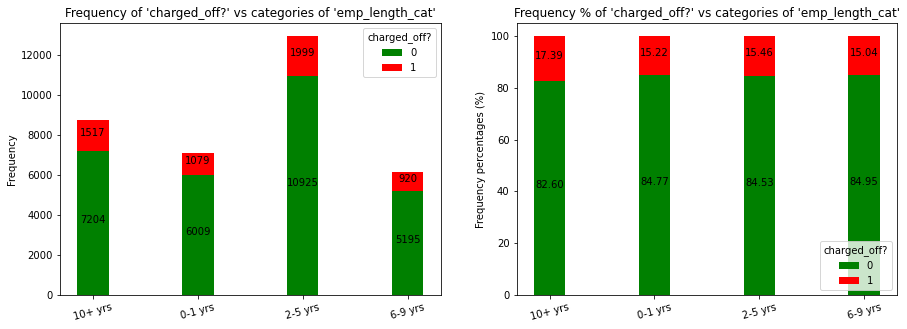

In [69]:
plot_freq_count_n_percentage(df_cat, 'emp_length_cat', 'charged_off?', 1)

No conclusions can be made for this column of the dataframe since all the categories have the same share of defaulters within them.


# Recommendation
Analysis of the data of the Lending Club reveals that the customers within the following categories are most probable to default and cause loss of business to the Lending Club:
- interest rate more than 20%
- 2 public records of bankruptcy
- loan term of 60 months
- loan of 30k-35k during all the stages of application by the customer, approving by the club, and investing by the investors.
- loan purpose of 'small business'
- LC assigned loan grade of 'G'

# Acknowledgement
- I would like to acknowledge the feedback, support and dataset provision by [upGrad](https://www.upgrad.com/gb/) and [The International Institute of Information Technology (IIIT), Bangalore](https://www.iiitb.ac.in/).
- Also, I would like to express my gratitude to [Aditya Bhattacharya](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/) for providing clarification and guidance to carry out this project. 
- Furthermore, the valuable feedback from [Dr Tayeb Jamali](https://www.linkedin.com/in/tayeb-jamali-b1a10937/) is highly appreciated.